In [1]:
import clickhouse_connect
import pandas as pd

In [2]:
client = clickhouse_connect.get_client(
    host='localhost',
    port=8123,
    username='ashwin',
    password='mysecret'
)

Create Database from Python

In [3]:
client.command("CREATE DATABASE IF NOT EXISTS training")
print("Database created!")

Database created!


Create Table from Python into clickhouse

In [4]:
create_table_query = """
CREATE TABLE IF NOT EXISTS training.sales (
    order_id UInt32,
    order_date Date,
    customer_id UInt32,
    region String,
    product String,
    category String,
    quantity UInt32,
    price Float64
)
ENGINE = MergeTree()
PARTITION BY toYYYYMM(order_date)
ORDER BY (region, order_date)
"""

client.command(create_table_query)
print("Table created!")


Table created!


Insert Data from Python

In [6]:
from datetime import date
data = [
    (1, date(2024, 1, 1), 101, 'North', 'Laptop', 'Electronics', 1, 800),
    (2, date(2024, 1, 2), 102, 'South', 'Phone', 'Electronics', 2, 500),
    (3, date(2024, 1, 5), 103, 'East', 'Table', 'Furniture', 1, 200),
    (4, date(2024, 1, 6), 101, 'North', 'Mouse', 'Electronics', 3, 20),
    (5, date(2024, 2, 1), 104, 'West', 'Chair', 'Furniture', 2, 150),
]

client.insert(
    'training.sales',
    data,
    column_names=[
        'order_id',
        'order_date',
        'customer_id',
        'region',
        'product',
        'category',
        'quantity',
        'price'
    ]
)

print("Data inserted successfully!")


Data inserted successfully!


Analytical Queries from Python

In [7]:
query="""
select sum(quantity*price) from training.sales
"""

df_total=client.query_df(query)

In [8]:
print(df_total)

   sum(multiply(quantity, price))
0                          2360.0


In [17]:
query="""
select region,sum(quantity*price) as reveune from 
training.sales group by region order by 2 desc
"""

In [18]:
df_region = client.query_df(query)
print(df_region)

  region  reveune
0  South   1000.0
1  North    860.0
2   West    300.0
3   East    200.0


In [19]:
df_region.describe()

,reveune
count,4.000000
mean,590.000000
std,398.831627
min,200.000000
25%,275.000000
50%,580.000000
75%,895.000000
max,1000.000000


Step 4: Visualize with Matplotlib

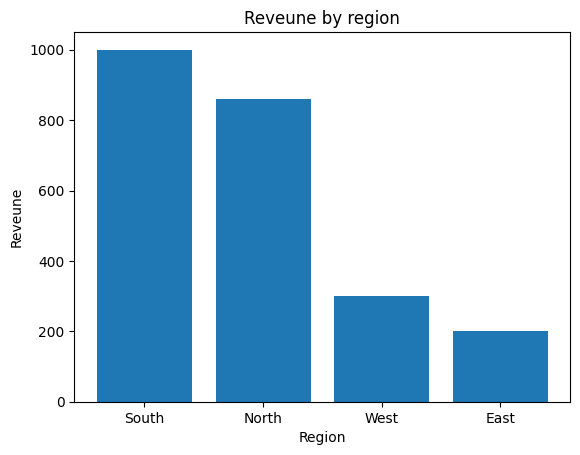

In [20]:
import matplotlib.pyplot as plt

plt.bar(df_region['region'],df_region['reveune'])
plt.xlabel("Region")
plt.ylabel("Reveune")
plt.title("Reveune by region")

plt.show()


Step 5: Monthly Revenue

In [21]:
query="""
select toYYYYMM(order_date) as month_sales,sum(quantity*price) as total_sales
from training.sales group by 1 order by 1
"""

In [22]:
df_month = client.query_df(query)
print(df_month)

   month_sales  total_sales
0       202401       2060.0
1       202402        300.0


Add Running Total in Python

In [24]:
df_month['running_total'] = df_month['total_sales'].cumsum()
print(df_month)

   month_sales  total_sales  running_total
0       202401       2060.0         2060.0
1       202402        300.0         2360.0


Plot Time Series

Text(0.5, 0, 'Month')

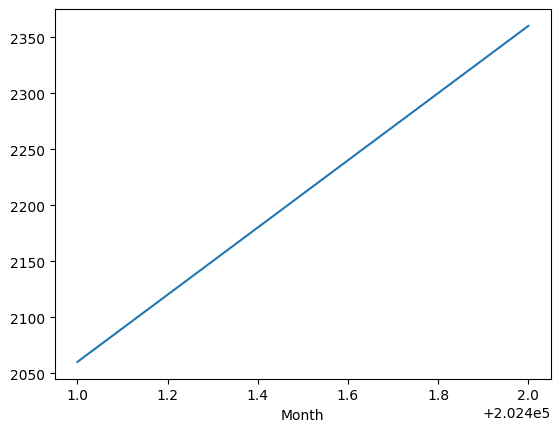

In [26]:
plt.figure()
plt.plot(df_month['month_sales'],df_month['running_total'])
plt.xlabel("Month")

In [30]:
import numpy as np

mean_reveunce=np.mean(df_month['total_sales'])
std_revenue = np.std(df_month['total_sales'])

In [31]:
mean_reveunce,std_revenue

(np.float64(1180.0), np.float64(880.0))

Advanced — Top 3 Products

In [32]:
query="""
select product,sum(quantity*price) as revenue from training.sales
group by product order by 2 desc limit 3
"""

In [33]:
df_top3= client.query_df(query)
print(df_top3)

  product  revenue
0   Phone   1000.0
1  Laptop    800.0
2   Chair    300.0


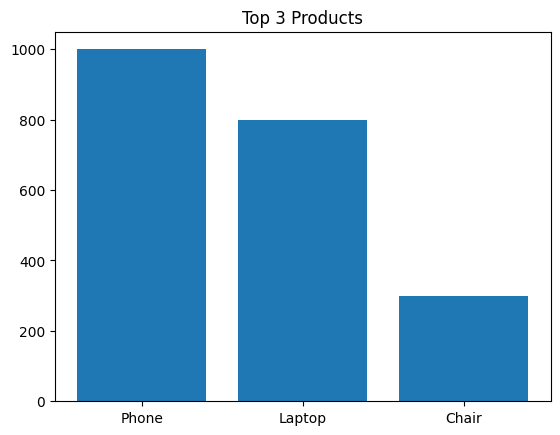

In [35]:
plt.figure()
plt.bar(df_top3['product'], df_top3['revenue'])
plt.title("Top 3 Products")
plt.show()